1. Preprocessing training set

In [214]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN



pd.set_option('display.max_rows', None)

X_file = "train_X.csv"
y_file = "train_y.csv"
df_X = pd.read_csv(X_file)
df_y = pd.read_csv(y_file)
df = pd.concat([df_X, df_y], axis=1)

one_hot_list = ["ethnicity", "gender", "icu_admit_source", 
                "icu_stay_type", "icu_type", "apache_3j_bodysystem", 
                "apache_2_bodysystem"
                ]

thres = 0.002


print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))
print("class0: {0}, class1: {1}\n".format(len(df[df["has_died"]==0]), len(df[df["has_died"]==1])))


# data cleaning
df.drop_duplicates(keep=False, inplace=True)
df.loc[df["apache_2_bodysystem"] == "Undefined diagnoses", "apache_2_bodysystem"] = "Undefined Diagnoses"


'''
missing data imputation
if dropna, train data 44939 -> 27868
'''
df_freq = df[one_hot_list]
df = df.drop(one_hot_list, axis=1)

# impute mean
for column in df.columns:
    arg = np.array(df[column]).reshape(-1, 1)
    imr = SimpleImputer(missing_values=np.nan, strategy='median').fit(arg)
    df[column] = imr.transform(arg)

# impute most frequent
for column in df_freq.columns:
    arg = np.array(df_freq[column]).reshape(-1, 1)
    imr = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit(arg)
    df_freq[column] = imr.transform(arg)
    
df = pd.concat([df, df_freq], axis=1)


# one-hot-encoding
df = pd.get_dummies(df, columns=one_hot_list)


# feature scaling
y_tmp = df['has_died']
df.drop('has_died', axis=1, inplace=True)

for feature in df.columns.values:
    scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
    df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))

df = pd.concat([df, y_tmp], axis=1)


# feature selection
y_tmp = df['has_died']
y = df['has_died'].values.astype(int)
df.drop('has_died', axis=1, inplace=True)
X = df.values

rf_model = RandomForestClassifier(
    # n_estimators=200, 
    # min_samples_split=2, #can tune
    # min_samples_leaf=1, #can tune
    # max_features='sqrt', 
    # max_depth=35, 
    # bootstrap=False,
    random_state=67,
    n_jobs=-1,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, y_train = SMOTEENN(n_jobs=-1, random_state=72).fit_resample(X_train, y_train) # resampling

rf_model.fit(X_train, y_train)

selector = SelectFromModel(rf_model, threshold=thres, prefit=True)
feature_idx = selector.get_support()

df = df[df.columns[feature_idx]]
df = pd.concat([df, y_tmp], axis=1)


print("\nremain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))
print("class0: {0}, class1: {1}".format(len(df[df["has_died"]==0]), len(df[df["has_died"]==1])))


# save preprocess result
df.to_csv("preprocess_"+X_file, encoding='utf-8', index=False)

origin data number: 44939
origin features: 83
class0: 41061, class1: 3878


remain data number: 44939
remain features: 80
class0: 41061, class1: 3878


2. Training & testing with internal testing set

F1 score (macro): 0.68
AUROC: 0.87
              precision    recall  f1-score   support

     class 0       0.97      0.87      0.91     12291
     class 1       0.33      0.68      0.45      1191

    accuracy                           0.85     13482
   macro avg       0.65      0.77      0.68     13482
weighted avg       0.91      0.85      0.87     13482



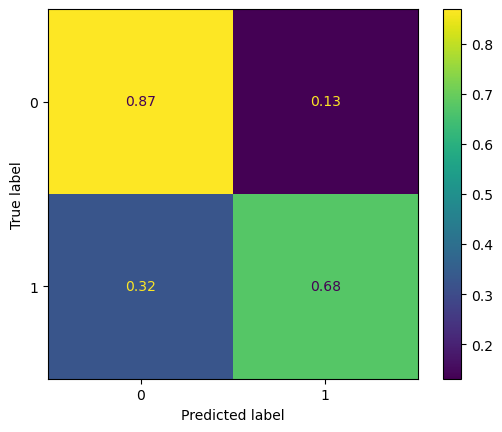

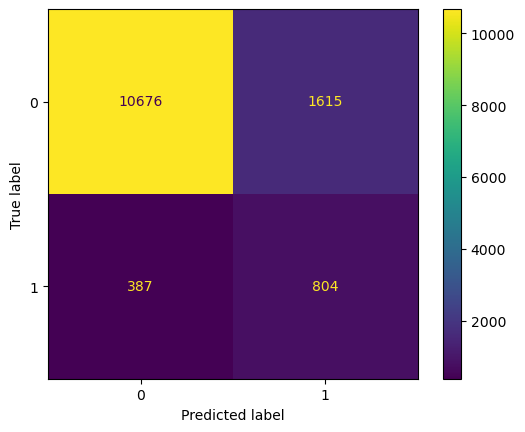

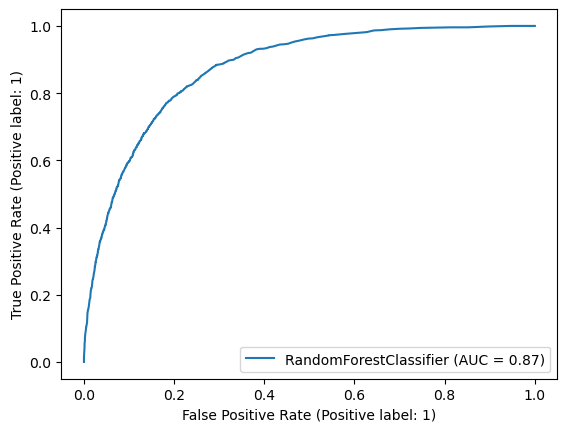

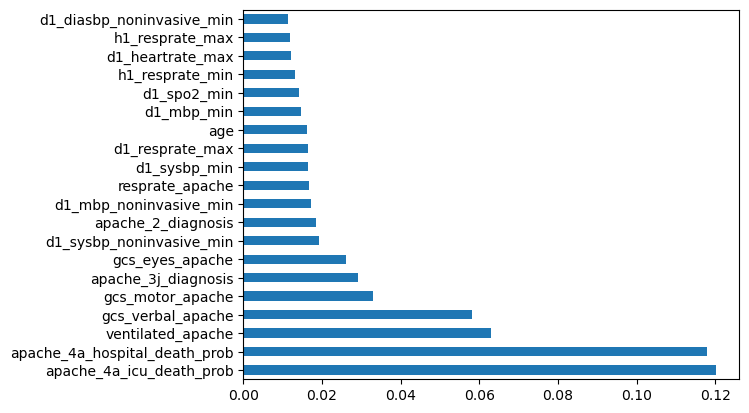

In [216]:
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN

# build model
rf_model = RandomForestClassifier(
    n_estimators=200, 
    min_samples_split=2, #can tune
    min_samples_leaf=1, #can tune
    max_features='sqrt', 
    max_depth=35, 
    bootstrap=False,
    random_state=67,
    n_jobs=-1,
)

model_filename = 'rf_model'
data_filename = "preprocess_train_X.csv"
df = pd.read_csv(data_filename)
y = df['has_died'].values.astype(int)
df.drop('has_died', axis=1, inplace=True)
X = df.values

# # tuning
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=87)
# X_train, y_train = SMOTEENN(n_jobs=-1, random_state=72).fit_resample(X_train, y_train) # resampling
# n_estimators = [int(x) for x in np.linspace(start=50, stop=500, num=10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(5, 50, num=10)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# # bootstrap = [True, False]

# random_grid = {'n_estimators': n_estimators, 'max_features': max_features,
#                'max_depth': max_depth, 'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
# # random_grid
# rf_random = RandomizedSearchCV(estimator = rf_model, param_distributions=random_grid,
#                               n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# rf_random.fit(X_train, y_train)
# print(rf_random.cv_results_)
# print(rf_random.best_params_)


# training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=87)

if os.path.exists(model_filename): # load the model from disk
    rf_model = pickle.load(open(model_filename, 'rb'))
else:
    X_train, y_train = SMOTEENN(n_jobs=-1, random_state=72).fit_resample(X_train, y_train) # resampling
    rf_model.fit(X_train, y_train)
    pickle.dump(rf_model, open(model_filename, 'wb')) # save the model to disk
y_score = rf_model.predict_proba(X_test)[:, 1] # for AUC curve
y_hat = rf_model.predict(X_test) # for f1 score


# evaluation
print("F1 score (macro): {:.2f}".format(f1_score(y_test, y_hat, average='macro')))
print("AUROC: {:.2f}".format(roc_auc_score(y_test, y_score)))
print(classification_report(y_test, y_hat, target_names=['class 0', 'class 1']))

# draw confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test, normalize='true')
ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)

# draw ROC curve
RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.show()

# plot important faetures
feat_importances = pd.Series(rf_model.feature_importances_, index=df.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


3. Preprocessing testing set

In [217]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler



pd.set_option('display.max_rows', None)

X_file = "test_X.csv"
df = pd.read_csv(X_file)

file_train = "preprocess_train_X.csv"
df_train = pd.read_csv(file_train)

one_hot_list = ["ethnicity", "gender", "icu_admit_source", 
                "icu_stay_type", "icu_type", "apache_3j_bodysystem", 
                "apache_2_bodysystem"
                ]


print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))


# data cleaning
df.loc[df["apache_2_bodysystem"] == "Undefined diagnoses", "apache_2_bodysystem"] = "Undefined Diagnoses"


# missing data imputation
df_freq = df[one_hot_list]
df = df.drop(one_hot_list, axis=1)

# impute mean
for column in df.columns:
    arg = np.array(df[column]).reshape(-1, 1)
    imr = SimpleImputer(missing_values=np.nan, strategy='median').fit(arg)
    df[column] = imr.transform(arg)

# impute most frequent
for column in df_freq.columns:
    arg = np.array(df_freq[column]).reshape(-1, 1)
    imr = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit(arg)
    df_freq[column] = imr.transform(arg)
    
df = pd.concat([df, df_freq], axis=1)


# one-hot-encoding
df = pd.get_dummies(df, columns=one_hot_list)


# feature scaling
for feature in df.columns.values:
    scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
    df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))


# feature selection
df_train.drop('has_died', axis=1, inplace=True)

selected_columns = df.columns.intersection(df_train.columns)
df = df[selected_columns]


print("\nremain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))


# save preprocess result
df.to_csv("preprocess_"+X_file, encoding='utf-8', index=False)

origin data number: 19260
origin features: 82

remain data number: 19260
remain features: 79


4. Testing 

In [218]:
from sklearn.feature_selection import SelectFromModel
import pandas as pd
import pickle

test_file = "preprocess_test_X.csv"
origin_test_file = "test_X.csv"
model_filename = 'rf_model'
df = pd.read_csv(test_file)
df_origin = pd.read_csv(origin_test_file)
X = df.values


# testing
rf_model = pickle.load(open(model_filename, 'rb'))
y_hat = rf_model.predict(X)


# save result
df_y = pd.DataFrame(y_hat, columns=['has_died'])
res = pd.concat([df_origin['patient_id'], df_y], axis=1)
res.sort_values(['patient_id'], ascending=True, inplace=True)


print("class0: {0}, class1: {1}".format(len(res[res["has_died"]==0]), len(res[res["has_died"]==1])))


res.to_csv("testing_result.csv", encoding='utf-8', index=False)

class0: 9735, class1: 9525
